# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Problem definition: The starbucks capstone challenge of “Udacity Machine Learning Engineer
nanodegree” provides the simulated data that mimics the starbucks rewards mobile application.
In this project, I will work on the given dataset in order to predict whether any customer would complete
an offer successfully or not, based on its demographic data and other details. This will help
starbucks to better decide/customize its offers based on the customers behaviour in order to make the maximum profit.

In [63]:
import pandas as pd
import numpy as np
import math
import json
import os
import re
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [64]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [65]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [66]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [67]:
#Number of rows and columns in portfolio, profile and transcript files respectively
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

# Data Cleaning


Portfolio:
    Apply one-hot encode on 'channels' and 'offer-type' columns,
    Rename 'id' to 'offer_id',
    Check for duplicates and null values (remove if any).
    
Profile:
    Drop all the rows of age '118' for being an outlier and having NULL values for other columns,
    Rename id as customer id,
    Transform the customer's gender to a number,
    Create columns for 'became_member_on' displaying year, month and date,
    Check for duplicates and null values (remove if any).
    
Transcript:
    Rename 'person' to 'customer_id,
    Remove the customer id data not present in profile's customer id,
    Change the time from hours to days,
    Create different columns for 'offer_id' and 'amount' from 'value' column,
    Separate the transaction and offer data,
    Apply one-hot encode on 'event' column,
    Check for duplicates and null values in both datasets (remove if any).

In [68]:
new_portfolio = portfolio.copy()
channels_array = []
for i in new_portfolio['channels']:
    for channel in i:
        if channel not in channels_array:
            channels_array.append(channel)
#channels_array
#Applying one hot encoder on channels columns
for channel in channels_array:
    new_portfolio[channel] = new_portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  
    
#Applying one hot encoder on offer_type columns
offer_type = pd.get_dummies(new_portfolio['offer_type'])

#Dropping off the channels and offer_type columns and concatenate the new columns
new_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
new_portfolio = pd.concat([new_portfolio, offer_type], axis=1, sort=False)

#Rename the id to offer_id
new_portfolio.rename(columns = {'id': 'offer_id'}, inplace=True)

new_portfolio

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


In [69]:
#checking duplicates
new_portfolio.duplicated().sum()

0

In [70]:
new_portfolio.isnull().any()

difficulty       False
duration         False
offer_id         False
reward           False
email            False
mobile           False
social           False
web              False
bogo             False
discount         False
informational    False
dtype: bool

In [71]:
# Drop all customers of age 118
new_profile = profile.copy()
new_profile = new_profile[new_profile['age'] < 118 ]
new_profile = new_profile.reset_index(drop=True)
new_profile.head()


,age,became_member_on,gender,id,income
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [72]:
#Checking if any column has any null value
new_profile.isnull().sum(axis=0)

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [73]:
#rename id as customer_id
new_profile.rename(columns = {'id': 'customer_id'}, inplace=True)
#create columns for became member on
new_profile['member_year'] = new_profile.became_member_on.apply(lambda x: int(str(x)[:4]))
new_profile['member_month'] = new_profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
new_profile['member_day'] = new_profile.became_member_on.apply(lambda x: int(str(x)[6:]))
new_profile.drop('became_member_on', axis = 1, inplace = True)
new_profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)
new_profile.head()

,age,gender,customer_id,income,member_year,member_month,member_day
0,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
1,75,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
2,68,0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
3,65,0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
4,58,0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11


In [74]:
#checking duplicates after cleaning
new_profile.duplicated().sum()

0

In [75]:
new_profile.isnull().any()

age             False
gender          False
customer_id     False
income          False
member_year     False
member_month    False
member_day      False
dtype: bool

In [76]:
new_transcript = transcript.copy()
new_transcript.rename(columns = {'person': 'customer_id'}, inplace=True)

#remove the customer id data not present in profile's customer id
new_transcript = new_transcript[new_transcript.customer_id.isin(new_profile.customer_id)]

#convert time
new_transcript['time'] /= 24.0

#extracting the offer_id (offer id or offer_id) and amount from 'value' column

def get_offer_id(data):
    try:
        return data['offer id']
    except KeyError:
        try:
            return data['offer_id']
        except:
            return 0
def get_amount(data):
    try:
        return data['amount']
    except KeyError:
        return 0

new_transcript['offer_id'] = new_transcript.value.apply(get_offer_id)
new_transcript['amount'] = new_transcript.value.apply(get_amount)

new_transcript.amount.astype('float')
new_transcript.drop(columns=['value'], inplace=True)

# divide the data of transaction and offer ids
new_transcript_transaction = new_transcript[new_transcript.event =='transaction'].copy()
new_transcript_transaction.drop(columns=['offer_id', 'event'], inplace=True)
new_transcript_transaction

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
12678,629fc02d56414d91bca360decdfa9288,0.00,33.90
12687,a97e6f33219c432db82acfa0d19c602d,0.00,18.59
12691,676506bad68e4161b9bbaffeb039626b,0.00,18.01
12696,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.00,19.11
12706,4cbe33c601a5407f8202086565c55111,0.00,36.19


In [77]:
new_transcript_transaction.duplicated().sum()

0

In [78]:
new_transcript_transaction.isnull().any()

customer_id    False
time           False
amount         False
dtype: bool

In [79]:
new_transcript_offers = new_transcript[new_transcript.event!='transaction'].copy()
new_transcript_offers =pd.get_dummies(new_transcript_offers,columns=['event'])
new_transcript_offers.drop(columns=['amount'], inplace=True)

new_transcript_offers

,customer_id,time,offer_id,event_offer completed,event_offer received,event_offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
9,31dda685af34476cad5bc968bdb01c53,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
12,4b0da7e80e5945209a1fdddfe813dbe0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0
13,c27e0d6ab72c455a8bb66d980963de60,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0
14,d53717f5400c4e84affdaeda9dd926b3,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
15,f806632c011441378d4646567f357a21,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0


In [80]:
new_transcript_offers.duplicated().sum()

374

In [81]:
new_transcript_offers.drop_duplicates(inplace=True)
#transcript.reset_index(drop=True, inplace=True)
new_transcript_offers

,customer_id,time,offer_id,event_offer completed,event_offer received,event_offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
9,31dda685af34476cad5bc968bdb01c53,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
12,4b0da7e80e5945209a1fdddfe813dbe0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0
13,c27e0d6ab72c455a8bb66d980963de60,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0
14,d53717f5400c4e84affdaeda9dd926b3,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
15,f806632c011441378d4646567f357a21,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0


In [82]:
new_transcript_offers.isnull().any()

customer_id              False
time                     False
offer_id                 False
event_offer completed    False
event_offer received     False
event_offer viewed       False
dtype: bool

# Exploratory data analysis

In [83]:
new_profile.describe()

,age,gender,income,member_year,member_month,member_day
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,0.499764,65404.991568,2016.620169,6.695582,15.904013
std,17.383705,0.500017,21598.299410,1.198245,3.488853,8.747571
min,18.000000,0.000000,30000.000000,2013.000000,1.000000,1.000000
25%,42.000000,0.000000,49000.000000,2016.000000,4.000000,8.000000
50%,55.000000,0.000000,64000.000000,2017.000000,7.000000,16.000000
75%,66.000000,1.000000,80000.000000,2017.000000,10.000000,23.000000
max,101.000000,1.000000,120000.000000,2018.000000,12.000000,31.000000


The mean of age, gender, income, membership year, month and day could be seen above. It shows that average customer age is 54 years. The average income of customers is $65404, average year of becoming member is 2016 and month & date's average is june and 15th respectively. Let's understand more through visualization.

Text(0.5,1,'Income Data')

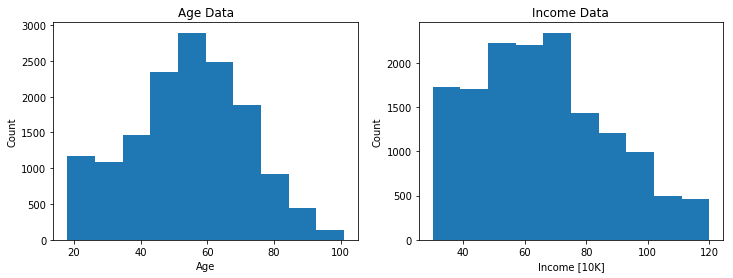

In [84]:
#Plotting customer's age and income
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

plt.sca(ax[0])
plt.hist(new_profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Data')

plt.sca(ax[1])
plt.hist(new_profile['income'] * 1E-3 )
plt.xlabel('Income [10K]')
plt.ylabel('Count')
plt.title('Income Data')

We can see the age distribution in our first plot, where average age is around 50s. The age of majority of customers is in the range of 50 to 70. Also, maximum people have their income of around 70000 Dollars. There are good number (3000) of people with lower income(40000 to 50000) and quite lesser people with highest incomes(100000 - 120000). Some of the EDA is done in next section as well for the dataset where customers complete the offer without even knowing or viewing the offer.

Text(0.5,1,'Date of becoming member Data')

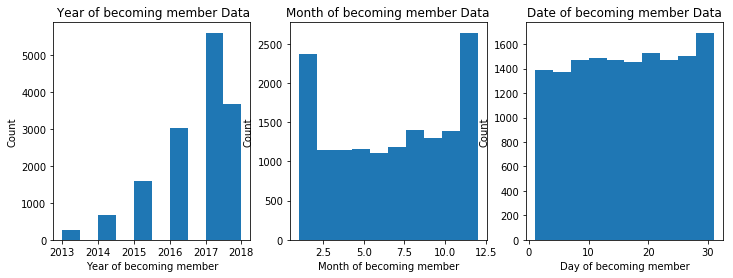

In [85]:
#Plotting customer's membership year, month and date
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

plt.sca(ax[0])
plt.hist(new_profile['member_year'])
plt.xlabel('Year of becoming member')
plt.ylabel('Count')
plt.title(' Year of becoming member Data')
plt.sca(ax[1])
plt.hist(new_profile['member_month'])
plt.xlabel('Month of becoming member')
plt.ylabel('Count')
plt.title('Month of becoming member Data');
plt.sca(ax[2])
plt.hist(new_profile['member_day'])
plt.xlabel('Day of becoming member')
plt.ylabel('Count')
plt.title('Date of becoming member Data')

Here, we can see that before 2017 there was constant increase in membership year, however in 2017 more than 5000 customers joined the starbucks. Looking into the membership month data, we can conclude that most of the people become member either in the starting of the year or at the end of an year. As far as days data is concerned, no such significant change is noticed apart from more count on the last date of month.

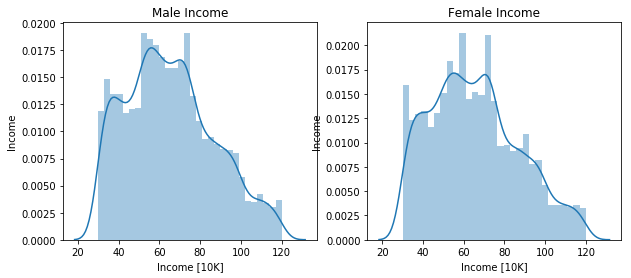

In [86]:
# plotting male and female income distribution
male_income = new_profile[new_profile['gender'] == 1]
female_income = new_profile[new_profile['gender'] == 0]
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
plt.sca(ax[0])
sns.distplot(male_income['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Income')
plt.sca(ax[1])
sns.distplot(female_income['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Income');

From the above plots, we can conclude that though the minimum and maximum incomes of both the genders are almost similar, the lowest income range has more male customers than females. Also, female customers have greater than or equal to income range for 60000 to 80000 income range. In general one expects females to have lower incomes than female but this dataset has something good to notice about.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7416 but corresponding boolean dimension is 8
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7409 but corresponding boolean dimension is 2
  stat_data = remove_na(group_data[hue_mask])


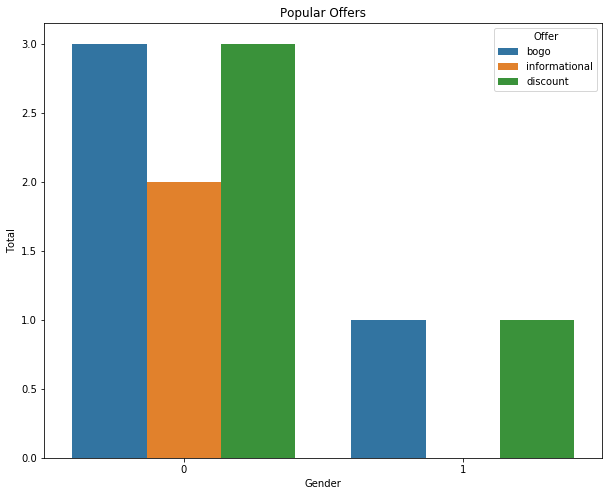

In [87]:
#plotting the offers type distribution amongst male and female customers
plt.figure(figsize=(10, 8))
sns.countplot(x=new_profile.gender, hue=portfolio.offer_type)
plt.title('Popular Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();


This plot shows that bogo and discount offer type is quite famous in male customers (0) in comparison to informational offer type. However, female (1) customers have quite lower count for bogo and discount in comparison with male customers, but unlike male customers, informational offer type is not bought by any female customer.

# Combining the dataset for Modelling

In [88]:
def combined_dataset(new_profile, new_portfolio, new_transcript_offers, new_transcript_transaction):
    
    combine_data = []
    customerid_list = new_transcript_offers['customer_id'].unique()
    
    # Iterate through every offer in a customer's profile
    for i in range(len(customerid_list)):
        new_customer_id = customerid_list[i]
        # Select a customer's profile
        customer = new_profile[new_profile['customer_id'] == new_customer_id]
        # Select the transcript's offer data with the help of customer's id
        customer_offer = new_transcript_offers[new_transcript_offers['customer_id']==new_customer_id]
        # Select the received, completed, viewed offer data from customer's offer data
        new_transcript_offer_received = customer_offer[customer_offer['event_offer received'] == 1]
        new_transcript_offer_completed = customer_offer[customer_offer['event_offer completed'] == 1]
        new_transcript_offer_viewed = customer_offer[customer_offer['event_offer viewed'] == 1]
        # Select the transcript's transaction data with the help of customer's id
        customer_transaction = new_transcript_transaction[new_transcript_transaction['customer_id']==new_customer_id]
        
        rows = []
        # loop through each received offer
        for j in range(new_transcript_offer_received.shape[0]):
            # Get an offer id 
            offer_id = new_transcript_offer_received.iloc[j]['offer_id']
            # Match and get the offer row from portfolio
            offer_row = new_portfolio.loc[new_portfolio['offer_id'] == offer_id]
            # Get the duration of an offer from offer row
            duration = offer_row['duration'].values[0]
            # initialize start and expire time of an offer
            start_time = new_transcript_offer_received.iloc[j]['time']
            expire_time = start_time + duration
            # Separate the offers completed within expiry date
            offer_completed_in_time = np.logical_and(new_transcript_offer_completed['time'] >= start_time, new_transcript_offer_completed['time'] <= expire_time)
            # Separate the offers viewed within expiry date
            offer_viewed_in_time = np.logical_and(new_transcript_offer_viewed['time'] >= start_time, new_transcript_offer_viewed['time'] <=expire_time)
            # Offer is successful if an offer is viewed and completed within expire time else to 0
            offer_successful = offer_completed_in_time.sum() > 0 and offer_viewed_in_time.sum() > 0
            # Recieved offers, never got viewed, but still got completed unknowignly
            offer_no_view_but_complete = offer_viewed_in_time.sum() <= 0 and offer_completed_in_time.sum() > 0
            # Select the transactions happened within time
            transaction_in_time = np.logical_and(customer_transaction['time'] >= start_time, customer_transaction['time'] <= expire_time)
            transaction_in_time_new = customer_transaction[transaction_in_time]
            
            # total amount spent by any customer
            transaction_total_amount = transaction_in_time_new['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': new_customer_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_knowingly_successful': int(offer_successful),
                'offer_unknowingly_completed': int(offer_no_view_but_complete)
            }
            
            row.update(offer_row.iloc[0,0:].to_dict())
            row.update(customer.iloc[0,:].to_dict())
            rows.append(row)
         
        combine_data.extend(rows)
            
    combine_data = pd.DataFrame(combine_data)
    return combine_data

In [89]:
combine_data = combined_dataset(new_profile, new_portfolio, new_transcript_offers, new_transcript_transaction)

In [90]:
combine_data

,age,bogo,customer_id,difficulty,discount,duration,email,gender,income,informational,...,member_year,mobile,offer_id,offer_knowingly_successful,offer_unknowingly_completed,reward,social,time,total_amount,web
0,75,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,7,1,0,100000.0,0,...,2017,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,5,0,0.0,37.67,1
1,75,0,78afa995795e4d85b5d9ceeca43f5fef,0,0,3,1,0,100000.0,1,...,2017,1,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,7.0,49.39,0
2,75,1,78afa995795e4d85b5d9ceeca43f5fef,10,0,7,1,0,100000.0,0,...,2017,1,ae264e3637204a6fb9bb56bc8210ddfd,1,0,10,1,17.0,48.28,0
3,75,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,5,1,0,100000.0,0,...,2017,1,f19421c1d4aa40978ebb69ca19b0e20d,1,0,5,1,21.0,48.28,1
4,68,0,e2127556f4f64592b11af22de27a7932,10,1,7,1,0,70000.0,0,...,2018,1,2906b810c7d4411798c6938adc9daaa5,0,0,2,0,0.0,0.00,1
5,68,0,e2127556f4f64592b11af22de27a7932,0,0,4,1,0,70000.0,1,...,2018,1,3f207df678b143eea3cee63160fa8bed,0,0,0,0,14.0,0.00,1
6,68,1,e2127556f4f64592b11af22de27a7932,5,0,7,1,0,70000.0,0,...,2018,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,5,0,17.0,18.42,1
7,68,0,e2127556f4f64592b11af22de27a7932,10,1,10,1,0,70000.0,0,...,2018,1,fafdcd668e3743c1bb461111dcafc2a4,1,0,2,1,21.0,18.42,1
8,65,1,389bc3fa690240e798340f5a15918d5c,5,0,5,1,0,53000.0,0,...,2018,1,f19421c1d4aa40978ebb69ca19b0e20d,1,0,5,1,0.0,9.54,1
9,65,1,389bc3fa690240e798340f5a15918d5c,5,0,7,1,0,53000.0,0,...,2018,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,0,7.0,0.00,1


In [91]:
list(combine_data)

['age',
 'bogo',
 'customer_id',
 'difficulty',
 'discount',
 'duration',
 'email',
 'gender',
 'income',
 'informational',
 'member_day',
 'member_month',
 'member_year',
 'mobile',
 'offer_id',
 'offer_knowingly_successful',
 'offer_unknowingly_completed',
 'reward',
 'social',
 'time',
 'total_amount',
 'web']

In [92]:
combine_data.offer_knowingly_successful.value_counts()

0    35136
1    31365
Name: offer_knowingly_successful, dtype: int64

In [93]:
combine_data.offer_unknowingly_completed.value_counts()

0    63180
1     3321
Name: offer_unknowingly_completed, dtype: int64

So, this shows that there are 3321 people who completed the offer without even viewing the offer. In such cases, from business point of view, there is no need to provide such people with these offers because anyhow they will complete it. Instead it would be beneficial to increase the offer (if sent) amount in future.

In [94]:
#Let's have a look at unknowingly completed offer data
offer_unknowingly_completed_data = combine_data[combine_data['offer_unknowingly_completed'] == 1]
offer_unknowingly_completed_data.head()

,age,bogo,customer_id,difficulty,discount,duration,email,gender,income,informational,...,member_year,mobile,offer_id,offer_knowingly_successful,offer_unknowingly_completed,reward,social,time,total_amount,web
65,96,0,868317b9be554cb18e50bc68484749a2,10,1,7,1,0,89000.0,0,...,2017,1,2906b810c7d4411798c6938adc9daaa5,0,1,2,0,0.0,12.03,1
69,96,0,868317b9be554cb18e50bc68484749a2,7,1,7,1,0,89000.0,0,...,2017,1,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,3,1,24.0,22.05,1
88,75,0,6e014185620b49bd98749f728747572f,10,1,7,1,0,40000.0,0,...,2015,1,2906b810c7d4411798c6938adc9daaa5,0,1,2,0,17.0,13.64,1
110,79,0,a3b9b4bf115e4564933ea2e4bc936843,10,1,7,1,0,48000.0,0,...,2015,1,2906b810c7d4411798c6938adc9daaa5,0,1,2,0,24.0,133.32,1
237,61,0,8b70ca1f5f5a45bdac2ac2f990b71526,10,1,7,1,1,98000.0,0,...,2017,1,2906b810c7d4411798c6938adc9daaa5,0,1,2,0,0.0,29.44,1


Understanding this unknowingly completed offer's data through VISUALIZATION

Text(0.5,0,'income')

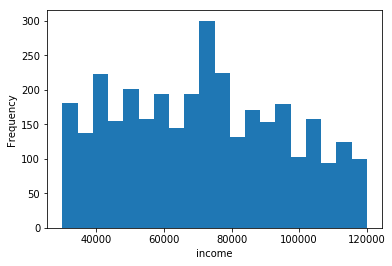

In [95]:
offer_unknowingly_completed_data.income.plot(kind="hist", bins=20)
plt.xlabel('income')

Customers who have unknowingly completed the offers have salaries in almost all the ranges, but a good count of these customers can be seen in the salary range of 70-75k. ALso customers with less that 50k salaries are more in count than the customers with more than 100k salaries.

Text(0.5,0,'age')

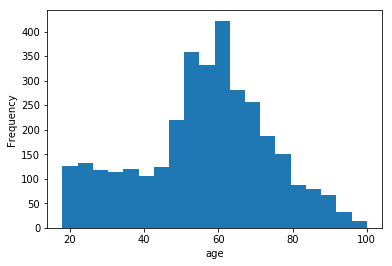

In [96]:
offer_unknowingly_completed_data.age.plot(kind="hist", bins=20)
plt.xlabel('age')

Customers unknowingly completing the offers have maximum count in the age group of 60. On an average it could be seen that from age group of around 55 to 75 years customers tend to complete the offers without even knowing that offer existed.

Text(0.5,0,'gender')

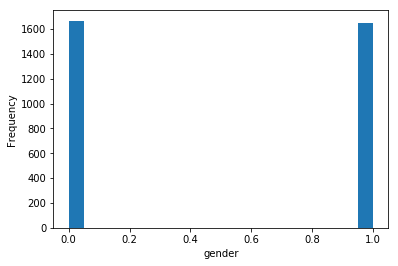

In [97]:
offer_unknowingly_completed_data.gender.plot(kind="hist", bins=20)
plt.xlabel('gender')

Both the genders have almost equal count of unknowingly completing the offers.

Now, preparing data for model

In [98]:
combine_data.to_csv('offer_analysis_dataset.csv', index=False)
combine_data = pd.read_csv('offer_analysis_dataset.csv')
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in combine_data.columns if elem not in column_ordering])
combine_data = combine_data[column_ordering]
combine_data.head()


,offer_id,total_amount,age,bogo,customer_id,difficulty,discount,duration,email,gender,...,member_day,member_month,member_year,mobile,offer_knowingly_successful,offer_unknowingly_completed,reward,social,time,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,75,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,7,1,0,...,9,5,2017,1,1,0,5,0,0.0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,75,0,78afa995795e4d85b5d9ceeca43f5fef,0,0,3,1,0,...,9,5,2017,1,0,0,0,1,7.0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,75,1,78afa995795e4d85b5d9ceeca43f5fef,10,0,7,1,0,...,9,5,2017,1,1,0,10,1,17.0,0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,75,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,5,1,0,...,9,5,2017,1,1,0,5,1,21.0,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,68,0,e2127556f4f64592b11af22de27a7932,10,1,7,1,0,...,26,4,2018,1,0,0,2,0,0.0,1


In [99]:
#Drop the columns having string values or columns not required for modelling
new_combine_data = combine_data.drop(columns=['time', 'customer_id'])
new_combine_data.head()

,offer_id,total_amount,age,bogo,difficulty,discount,duration,email,gender,income,informational,member_day,member_month,member_year,mobile,offer_knowingly_successful,offer_unknowingly_completed,reward,social,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,75,1,5,0,7,1,0,100000.0,0,9,5,2017,1,1,0,5,0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,75,0,0,0,3,1,0,100000.0,1,9,5,2017,1,0,0,0,1,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,75,1,10,0,7,1,0,100000.0,0,9,5,2017,1,1,0,10,1,0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,75,1,5,0,5,1,0,100000.0,0,9,5,2017,1,1,0,5,1,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,68,0,10,1,7,1,0,70000.0,0,26,4,2018,1,0,0,2,0,1


# Data Modelling

Splitting the data for training and testing and then building the machine learning models using Logistic regression and then Random forest search. First of all, label would be "offer_knowingly_successful". These models will help in predicting if the offers would be successful or not i.e. if the customer will respond to the offer or not. Secondly, if we want to predict the customers and their demographics i.e. who will complete the offer without even viewing it, we will need to put  "offer_unknowingly_completed" as the label and customer's details as features. In case someone needs this prediction, I have trained another model as well in the end.

To predict if the offer would be successful or not

In [100]:
nnew_combine_data = new_combine_data.drop(columns=['offer_unknowingly_completed'])
features = nnew_combine_data.drop(columns=['offer_knowingly_successful'])
label = nnew_combine_data.filter(['offer_knowingly_successful'])
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')
y_train = y_train.ravel()
y_test = y_test.ravel()

In [101]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


In [102]:
scorer = make_scorer(fbeta_score, beta=0.5)

# instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total= 1.0min
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   2.2s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   2.4s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   2.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................................ penalty=l1, C=0.1, total=  12.6s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=6, n_jobs=3,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [103]:
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [104]:
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.690
LogisticRegression model f1-score: 0.687


(0.69026852846401721, 0.68698710433763199)

In [105]:
evaluate_model_performance(lr_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.698
RandomizedSearchCV model f1-score: 0.695


(0.69775951080146359, 0.69468354430379753)

In [106]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   1.0s
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  3.0min


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   7.1s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   7.0s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   7.0s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  20.6s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  20.6s
[CV]  n_estimators=250, min_samples_split=5, min_samples_lea

[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   4.1s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   4.1s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  16.7s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  16.7s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_featu

[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   6.2s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=au

[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6, total=   0.7s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 10.7min


[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.5s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.5s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=

[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  22.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  22.0s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   3.0s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   3.1s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sq

[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, total=  30.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, total=  30.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   5.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.9s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.9s
[CV] n_estimators=200, min_samples_split=2, min_sampl

[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=   8.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   5.9s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   5.9s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   5.9s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_fe

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 21.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [107]:
# evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.874
RandomForestClassifier model f1-score: 0.866


(0.87353383458646616, 0.86572542937298991)

The results clearly showed us that out of Naive, Logistic Regression and Random Forest Classifier, Random forest classifier performed the best

In [108]:
#evaluating the test data's performance
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.740
RandomForestClassifier model f1-score: 0.724


(0.73991278632649993, 0.72373955172230198)

# Refined model

In [109]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [250, 300, 350, 400, 450]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(11, 16)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [8, 10, 12]

# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 4, 5]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 5,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13 
[CV] n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13 
[CV] n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13 
[CV]  n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13, total=  57.8s
[CV] n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13 
[CV]  n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13, total=  57.9s
[CV] n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13 
[CV]  n_estimators=450, min_samples_split=8, min_samples_leaf=3, max_features=sqrt, max_depth=13, total=  58.0s
[CV] n_estimators=400, min_samples_split=12, min_samples_leaf=4, max_features=sqrt, max_depth=11 
[CV]  n_estimators

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 11.0min


[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=15, total=  55.9s
[CV] n_estimators=400, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=15 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=15, total=  55.3s
[CV] n_estimators=400, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=15 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=15, total=  55.5s
[CV] n_estimators=350, min_samples_split=12, min_samples_leaf=4, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=15, total=  55.7s
[CV] n_estimators=350, min_samples_split=12, min_samples_leaf=4, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=15, total=  55.2s
[CV] n_estimators=350, min_samples_split=12

[CV]  n_estimators=350, min_samples_split=8, min_samples_leaf=3, max_features=auto, max_depth=14, total=  47.0s
[CV] n_estimators=250, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=13 
[CV]  n_estimators=350, min_samples_split=8, min_samples_leaf=3, max_features=auto, max_depth=14, total=  47.0s
[CV] n_estimators=250, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=13 
[CV]  n_estimators=250, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=13, total=  32.5s
[CV] n_estimators=250, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=13 
[CV]  n_estimators=250, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=13, total=  32.5s
[CV] n_estimators=450, min_samples_split=12, min_samples_leaf=5, max_features=auto, max_depth=None 
[CV]  n_estimators=250, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=13, total=  32.5s
[CV] n_estimators=450, min_samples_split=12, min_

[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=4, max_features=auto, max_depth=14, total=  54.3s
[CV] n_estimators=350, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=4, max_features=auto, max_depth=14, total=  53.9s
[CV] n_estimators=350, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=350, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  43.2s
[CV] n_estimators=350, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=350, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  43.5s
[CV] n_estimators=350, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=350, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  43.0s
[CV] n_estimators=450, min_samples_split=12, min_s

[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=15, total=  41.2s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=15, total=  41.1s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  35.9s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=15, total=  40.7s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 44.0min


[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  36.3s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  36.6s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=13 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  36.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=13 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=12, total=  36.3s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=13 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=13, total=  31.9s
[CV] n_estimators=250, min_samples_split=10

[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=13, total=  51.8s
[CV] n_estimators=400, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=13 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=13, total=  51.9s
[CV] n_estimators=400, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=13 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=13, total=  51.9s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=3, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=13, total=  51.6s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=3, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=13, total=  51.8s
[CV] n_estimators=300, min_samples_split=10

[CV]  n_estimators=350, min_samples_split=8, min_samples_leaf=3, max_features=auto, max_depth=15, total=  52.2s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=15 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=15, total=  44.0s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=15 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=15, total=  44.4s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=15 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=15, total=  44.9s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=None 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=15, total=  43.6s
[CV] n_estimators=400, min_samples_split=1

[CV]  n_estimators=250, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=14, total=  34.3s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=None, total=  59.8s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=None, total=  60.0s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=14 
[CV]  n_estimators=250, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=14, total=  33.5s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=14 
[CV]  n_estimators=250, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=14, total=  33.5s
[CV] n_estimators=450, min_samples_split=

[CV]  n_estimators=300, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  38.3s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=None 
[CV]  n_estimators=300, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  38.2s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=None 
[CV]  n_estimators=300, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  38.3s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=None 
[CV]  n_estimators=250, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=None, total=  39.3s
[CV] n_estimators=250, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=None 
[CV]  n_estimators=250, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=None, total=  40.1s
[CV] n_estimators=250, min_samples

[CV]  n_estimators=400, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  52.8s
[CV] n_estimators=400, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11 
[CV]  n_estimators=400, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  51.6s
[CV] n_estimators=450, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=12 
[CV]  n_estimators=400, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  48.3s
[CV] n_estimators=450, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=12 
[CV]  n_estimators=400, min_samples_split=8, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  48.1s
[CV] n_estimators=450, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=12 
[CV]  n_estimators=450, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=12, total=  57.1s
[CV] n_estimators=450, min_samples_split=12, min

[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 107.6min


[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=14, total=  34.6s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=14 
[CV]  n_estimators=450, min_samples_split=12, min_samples_leaf=3, max_features=sqrt, max_depth=12, total=  57.1s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=14 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=14, total=  34.5s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=14 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=14, total=  34.7s
[CV] n_estimators=400, min_samples_split=12, min_samples_leaf=4, max_features=auto, max_depth=13 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=14, total=  34.4s
[CV] n_estimators=400, min_samples_split=12

[CV]  n_estimators=350, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  40.0s
[CV] n_estimators=350, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=13 
[CV]  n_estimators=350, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=11, total=  39.8s
[CV] n_estimators=350, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=13 
[CV]  n_estimators=350, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=13, total=  43.2s
[CV] n_estimators=350, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=13 
[CV]  n_estimators=350, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=13, total=  43.4s
[CV] n_estimators=350, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=13 
[CV]  n_estimators=350, min_samples_split=12, min_samples_leaf=3, max_features=auto, max_depth=13, total=  42.9s
[CV] n_estimators=400, min_samples_split=8,

[CV]  n_estimators=350, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=11, total=  36.8s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=350, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=11, total=  37.4s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=350, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=11, total=  37.2s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=14, total=  36.1s
[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=sqrt, max_depth=14, total=  36.8s
[CV] n_estimators=300, min_samples_split=12

[CV] n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=auto, max_depth=12 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=auto, max_depth=12, total=  33.3s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=15 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=auto, max_depth=12, total=  33.8s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=15 
[CV]  n_estimators=300, min_samples_split=12, min_samples_leaf=5, max_features=auto, max_depth=12, total=  33.8s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=15 
[CV]  n_estimators=450, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=15, total=  57.4s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=15 
[CV]  n_estimators=450, min_samples_split=10, min_samples_

[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 145.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [250, 300, 350, 400, 450], 'max_features': ['auto', 'sqrt'], 'max_depth': [11, 12, 13, 14, 15, None], 'min_samples_split': [8, 10, 12], 'min_samples_leaf': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [110]:
# evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.867
RandomForestClassifier model f1-score: 0.859


(0.86691729323308275, 0.85853257518668236)

In [111]:
#evaluating the test data's performance
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.743
RandomForestClassifier model f1-score: 0.726


(0.74261941757305394, 0.72649800266311582)

Building model to predict unknowingly completed offer

In [112]:
unknowingly_combine_data = combine_data.drop(columns=['offer_id', 'bogo', 'difficulty', 'discount', 'duration', 'email', 'informational', 'offer_knowingly_successful', 'reward', 'social', 'time', 'web', 'mobile'])
column_ordering = ['customer_id', 'total_amount']
column_ordering.extend([elem for elem in unknowingly_combine_data.columns if elem not in column_ordering])
unknowingly_combine_data = unknowingly_combine_data[column_ordering]
unknowingly_combine_data.head()

,customer_id,total_amount,age,gender,income,member_day,member_month,member_year,offer_unknowingly_completed
0,78afa995795e4d85b5d9ceeca43f5fef,37.67,75,0,100000.0,9,5,2017,0
1,78afa995795e4d85b5d9ceeca43f5fef,49.39,75,0,100000.0,9,5,2017,0
2,78afa995795e4d85b5d9ceeca43f5fef,48.28,75,0,100000.0,9,5,2017,0
3,78afa995795e4d85b5d9ceeca43f5fef,48.28,75,0,100000.0,9,5,2017,0
4,e2127556f4f64592b11af22de27a7932,0.00,68,0,70000.0,26,4,2018,0


In [113]:
features = unknowingly_combine_data.drop(columns=['offer_unknowingly_completed'])
label = unknowingly_combine_data.filter(['offer_unknowingly_completed'])
x_train, x_test, Y_train, Y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)
customer_id_train = x_train[:, 0]
total_amount_train = x_train[:, 1]
x_train = x_train[:, 2:].astype('float64')
offer_id_test = x_test[:, 0]
total_amount_test = x_test[:, 1]
x_test = x_test[:, 2:].astype('float64')
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

In [114]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(x_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.8s
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, total=  15.2s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, total=  15.2s
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, total=  15.2s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6 
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6, total=   0.6s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=6 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6, total=   0.6s
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6, total=   0.6s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=6 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=6, total=  13.4s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=6, total=  13.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=6, total=  13.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=  13.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=  13.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=  13.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, total=   7.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, total=   7.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, total=   7.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7, total=  11.6s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7, total=  11.6s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7, total=  11.6s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, total=   0.4s
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, total=   0.4s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, total=   0.4s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, total=  25.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, total=  26.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, total=  26.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=  15.2s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=  15.1s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=  15.1s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9, total=  21.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9, total=  21.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9, total=  21.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   3.4s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   3.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.4min


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   3.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.1s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.1s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.1s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  17.8s
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  17.8s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  17.8s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   9.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   9.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   9.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, total=  15.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, total=  15.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, total=  15.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=  13.3s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=  13.3s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=  13.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.8s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.8s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, m

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   3.4s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   3.3s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=   0.6s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   3.4s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=   0.6s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=   0.6s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   5.7s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   5.7s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   5.7s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5, total=   7.2s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5, total=   7.2s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5, total=   7.2s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=  11.5s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=  11.5s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=  11.5s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4, total=   4.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4, total=   4.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4, total=   4.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4, total=   8.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4, total=   8.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=4, total=   8.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   3.7s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   3.8s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   3.8s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  14.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  14.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  14.1s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5, total=   4.9s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5, total=   5.0s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5, total=   5.0s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   2.4s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   2.4s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   2.5s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   8.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   8.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   8.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, total=   1.9s
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, total=   1.9s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   0.6s
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   0.6s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, total=   2.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   0.8s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=   0.9s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=  11.7s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=  11.5s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=  11.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, total=   3.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, total=   3.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, total=   3.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3, total=   3.8s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3, total=   3.7s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3, total=   3.6s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, total=  19.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, total=  19.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, total=  19.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, total=  19.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, total=  20.0s
[CV] n_estimators=100, min_samples_split=1

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   5.3s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   5.2s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   5.2s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.6s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   4.7s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   4.7s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   4.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6, total=   5.5s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6, total=   5.3s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6, total=   5.3s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, total=  23.1s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=4 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, total=  23.0s
[CV] n_estimators=150, min_samples_split=5, min_sampl

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=4, total=   6.1s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=4, total=   6.2s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=4, total=   6.3s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  17.8s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  17.8s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  17.9s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=   1.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=   1.1s
[CV] n_estimators=200, min_samples_split=2, min_sam

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   6.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   6.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   6.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7, total=  17.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7, total=  18.0s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7, total=  18.0s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, total=  20.5s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, total=  20.7s
[CV] n_estimators=300, min_samples_split=2, mi

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  19.7s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  19.7s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  19.7s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  12.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  12.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  12.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6, total=   0.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6, total=   0.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6, total=   0.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  9.0min
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.0s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.0s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.0s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9, total=  10.6s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=3 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9, total=  10.6s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=3, total=   0.4s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=3 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=3, total=   0.4s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9, total=  10.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=3, total=   0.4s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  15.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  15.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  15.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, total=  20.0s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, total=  19.7s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, total=  20.1s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   6.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   6.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   6.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  14.4s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  14.4s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  14.4s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=3 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.0s
[CV] n_estimators=100, min_samples_split=5, mi

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=3, total=   3.4s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=3, total=   3.5s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=3, total=   3.5s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=  13.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=  13.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=  13.8s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=  24.8s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=  24.6s
[CV] n_estimators=250, min_samples_split=5, m

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  19.5s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  19.6s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  19.5s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   2.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   2.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   2.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7, total=  14.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7, total=  14.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7, total=  14.8s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=  16.3s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=7 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=  16.3s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=7 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=  16.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=7, total=   3.3s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=7, total=   3.3s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=7, total=   3.3s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7, total=  15.0s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7, total=  15.0s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=7, total=  14.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=  14.4s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=  14.4s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=  14.4s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   9.8s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   9.7s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   9.7s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6, total=  16.6s
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6, total=  16.7s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=6, total=  16.6s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=  18.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=  18.1s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=  18.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  14.6s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=4 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  14.6s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=4 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  14.7s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=4, total=  12.4s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=8 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=4, total=  12.4s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=8 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=4, total=  12.4s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=8, total=  10.2s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=8, total=  10.2s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=8, total=  10.2s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, total=  25.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, total=  25.7s
[CV] n_estimators=100, min_samples_split=

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   9.6s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=3 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   9.5s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=3 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   9.6s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=3 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=3, total=   5.2s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=4 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=3, total=   5.2s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=4 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=3, total=   5.2s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   6.4s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   6.3s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   6.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, total=   5.3s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, total=   5.4s
[CV] n_estimators=150, min_samples_split=10, min_s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, total=  10.3s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, total=  10.3s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, total=  10.3s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  13.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=4 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  13.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   0.5s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=4 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  13.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   0.5s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   0.5s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4, total=  12.7s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4, total=  12.7s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4, total=  12.8s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=  12.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=  12.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=  12.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   9.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   9.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   9.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=   7.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=   7.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=   7.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   4.8s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   4.8s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4, total=   0.5s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4, total=   0.5s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   4.9s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4, total=   0.5s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7, total=  14.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=6 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7, total=  14.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=6 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=7, total=  14.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=6, total=   5.6s
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=6, total=   5.5s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=6, total=   5.6s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=   2.4s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=   2.4s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=   2.5s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   7.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   7.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   7.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   3.9s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   4.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   4.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   9.8s
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   9.9s
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   9.9s


[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 17.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [115]:
# evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, x_train, Y_train)

RandomForestClassifier model accuracy: 0.956
RandomForestClassifier model f1-score: 0.307


(0.95604726100966697, 0.30737982396750169)

The model accuracy here is too good, but we can see that the f1- score is quite low. Due to low label class examples in this training dataset, sometimes these labels are never predicted by the model, due to which f1-score gets divided by the 0 in those cases making the f1-score low. Make sure to use this model only when you have a good dataset with plenty of label class examples.

# Conclusion

In order to predict whether the offer would be successful or not ie. whether the customer would choose an offer or not, my strategy was to clean the given three datasets of portfolio, profile and transcript. After this I combined these three datasets in order to perform modelling on them. Since, we wanted to perform if the offer would be successful or not, we put this as label and rest others as features in the models. After this, I evaluated the accuracy and f1-score of naive model, logistic regression and random forest models. Out of these, random forest model gave the highest accuracy and f1-score on training data. The accuracy and f1-score on the test data of 0.740 and 0.724 respectively shows that overfitting was also avoided by this model. Lastly, since from business point of view, I feel it is equally important to know that if any customer is unknowingly completing the offer then it should be avoided to send him offer and rewards options because anyhow he will complete it. Though we didn't have plenty of label examples in this dataset which lead to a low f1-score, predicting this label is also equally valuable to run a good business.